<a href="https://colab.research.google.com/github/KwancheolShin/Understanding-information-and-AI-with-mathematics/blob/main/multi_class_classification_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
shape of an image: (28, 28)
label is 0


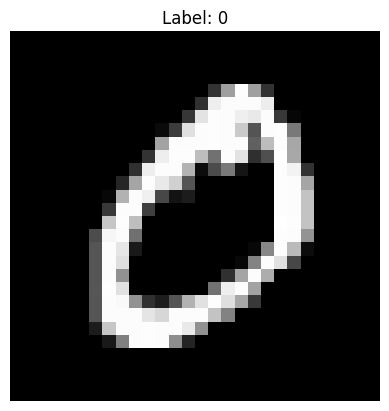

x_train shape (60000, 784)
x_test  shape (10000, 784)
t_train shape (60000, 10)
t_test  shape (10000, 10)



In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon May 19 17:29:18 2025

@author: kcshi
"""
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

# Data load
(x_train_o, t_train_o), (x_test_o, t_test_o) = mnist.load_data()

# Show an example
img   = x_train_o[1] # read first data
label = t_train_o[1] # read the label
print("shape of an image:", img.shape)  # (28, 28)
print("label is", label)

plt.imshow(img, cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()
plt.close()

# input data flattening/ target data one-hot incoding
from tensorflow.keras.utils import to_categorical

x_train = x_train_o.reshape(x_train_o.shape[0],-1) # (60000, 784)
x_test  =  x_test_o.reshape(x_test_o.shape[0],-1 ) # (10000, 784)
# x_train = x_train_o.reshape(x_train_o.shape[0],-1).astype(np.float32) / 255.0 # (60000, 784)
# x_test  =  x_test_o.reshape(x_test_o.shape[0],-1 ).astype(np.float32) / 255.0 # (10000, 784)

t_train = to_categorical(t_train_o, num_classes = 10) # one-hot incoding
t_test  = to_categorical(t_test_o, num_classes = 10)  # one-hot incoding


print("x_train shape", x_train.shape) #check the shape of the data
print("x_test  shape", x_test.shape)
print("t_train shape", t_train.shape)
print("t_test  shape", t_test.shape)
print("==============\n")

In [2]:

# define classes for layers
class Relu:
    def __init__(self):
        self.mask = None
        self.out  = None

    def forward(self,x):
        # self.mask = (x<=0)
        # out = x.copy()
        # out[self.mask]=0
        self.out = np.where(x>0,x,0)
        return self.out

    def backward(self,dout):
        # dout[self.mask] =0
        # dx = dout
        dx = np.where(self.out>0,dout,0)
        return dx


class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self,x):
        out = 1/(1+np.exp(-x))
        self.out = out

        return self.out

    def backward(self,dout):
        dx = self.out*(1.0-self.out)*dout

        return dx


class Affine:
    def __init__(self,W,b):
        self.W = W
        self.b = b
        self.dW = None
        self.db = None
        self.x = None

    def forward(self,x):
        self.x = x
        out  = np.matmul(self.x,self.W) + self.b

        return out

    def backward(self,dLdy):
        h = dLdy.shape[0]
        dLdx = np.matmul(dLdy,self.W.T)
        self.dW = np.matmul(self.x.T,dLdy)/h
        self.db = np.sum(dLdy,axis=0)/h

        return dLdx

def softmax(x):
    x = x-np.max(x,axis=1,keepdims=True)
    exp_x = np.exp(x)

    return exp_x/np.sum(exp_x,axis=1,keepdims=True)


def cross_entropy_error(y,t):
    #y: output of the Neural network
    #t: label
    h = y.shape[0] # mini-batch size

    return -np.sum(t*np.log(y + 1e-7))/h


class SoftmaxWithCrossEntropy: # Cross Entropy loss
    def __init__(self):
        self.loss = None # 손실
        self.y = None    # softmax의 출력
        self.t = None

    def forward(self,x,t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y,self.t)

        return self.loss

    def backward(self,dout=1):
        #batch_size = self.t.shape[0]
        dx = (self.y - self.t)
        return dx


class SoftmaxWithMSE: # Mean-Square-Error loss
    def __init__(self):
        self.loss = None
        self.y = None # Softmax 결과
        self.t = None

    def forward(self,x,t):
        self.t = t
        self.y = softmax(x)
        self.loss = 0.5*np.mean((self.y - self.t)**2)

        return self.loss

    def backward(self,dout=1):
        B, K = self.t.shape
        dx = np.zeros_like(self.y)

        for i in range(B): # 미니배치에 대한 연산을 한꺼번에 하기는 힘들고 for loop를 돌려야하는 것 같음 =>Cross-Entropy 보다 계산이 많음
            y_i  = self.y[i] # shape: (K,)
            t_i  = self.t[i] # shape: (K,)
            dy_i = y_i - t_i # shape: (K,)

            J = np.diag(y_i) - np.outer(y_i,y_i)
            dx[i] = np.matmul(J, dy_i) #shape: (K,)

        dx = (dout/B)*dx
        return dx

#define Neural Network Architecture
class TwoLayerNet:
    def __init__(self,input_size,hidden_size,output_size,weight_init_std=0.01):
        #__init__ 함수를 이용해서 클래스 속성변수를 초기화하는 부분
        self.params ={} #empty dictionary to save trainable parameters below
        self.params['W1'] = weight_init_std*np.random.randn(input_size,hidden_size) # random initialization
        self.params['b1'] = np.zeros(hidden_size) # zero initialization
        self.params['W2'] = weight_init_std*np.random.randn(hidden_size,output_size)
        self.params['b2'] = np.zeros(output_size)

        self.grads = {}  #empty dictionary to save gradients of the parameters

        #define layers
        self.Affine1   = Affine(self.params['W1'],self.params['b1']) # 1_st hidden layer
        self.actv      = Relu()                                      # activation/ Choose either Relu or Sigmoid class
        self.Affine2   = Affine(self.params['W2'],self.params['b2']) # 2_nd hidden layer
        self.lastLayer = SoftmaxWithCrossEntropy()                  # last layer: softmax layers + Cross-Entropy loss layer
        #self.lastLayer = SoftmaxWithMSE()                          # last layer: softmax layers + MSE loss layer

    #순전파 함수
    def forward(self,x,t):
        a1 = self.Affine1.forward(x)
        z1 = self.actv.forward(a1)
        a2 = self.Affine2.forward(z1)
        loss  = self.lastLayer.forward(a2,t)
        return a2, loss

    #역전파 함수
    def backward(self,x,t):
        dout = 1
        douta2 = self.lastLayer.backward(dout)
        doutz1 = self.Affine2.backward(douta2)
        douta1 = self.actv.backward(doutz1)
        doutx  = self.Affine1.backward(douta1)

        self.grads['dW1'] = self.Affine1.dW
        self.grads['db1'] = self.Affine1.db
        self.grads['dW2'] = self.Affine2.dW
        self.grads['db2'] = self.Affine2.db

        return self.grads

    #경사하강법 함수
    def step(self,lr): # update parameters by gradient decent step
        self.Affine1.W -= lr*self.Affine1.dW
        self.Affine1.b -= lr*self.Affine1.db
        self.Affine2.W -= lr*self.Affine2.dW
        self.Affine2.b -= lr*self.Affine2.db

    #훈련과정에서 정확도를 측정하는 함수
    def accuracy(self,x,t):
        y,loss = self.forward(x,t)
        y = np.argmax(y,axis=1)
        if t.ndim !=1 : t= np.argmax(t,axis = 1)

        accuracy= np.sum(y==t)/float(x.shape[0])
        return accuracy

    #훈련이 끝난 뒤, 훈련된 네트워크를 이용하여 숫자를 판별하는 함수
    def predict(self,sample_id):
        x = x_test[sample_id].reshape(1, -1)
        t = t_test[sample_id].reshape(1, -1)
        y, _ = self.forward(x, t)

        t_predict = np.argmax(y)
        t_true = np.argmax(t)

        x_img = x_test[sample_id].reshape(28,28)

        plt.imshow(x_img, cmap='gray')
        plt.axis('off')
        plt.show()

        print("predicted value is: ", t_predict)
        print("true target is: ", t_true)

# 이제 class로 구조를 다 만들었으므로 본격적으로 네트워크를 하나 만들어서 훈련을 시작함

# define a network instance: 훈련할 네트워크를 하나 만듦
network = TwoLayerNet(input_size = 784, hidden_size=100, output_size=10)

# training hyper-parameters: 하이퍼파라미터 설정
iters_num = 20_000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.001

#훈련과정을 모니터링하기 위해 빈 리스트를 만들어 훈련과정을 기록함
train_loss_list = []
train_acc_list  = []
test_acc_list   = []

iter_per_epoch = max(train_size/batch_size,1)


print("Training started ...")
#미니배치 학습 시작
for i in range(iters_num):
    batch_mask = np.random.choice(train_size,batch_size) #미니배치 크기 숫자만큼 데이터를 렌덤으로 선택하기 위해 랜덤하기 인덱스를 초기화
    x_batch = x_train[batch_mask] # 슬라이싱을 이용하여 미니배치 크기만큼 뽑아냄
    t_batch = t_train[batch_mask]

    _, loss  = network.forward(x_batch,t_batch)  # 순전파 시행
    grads    = network.backward(x_batch,t_batch) # 역전파 시행
    network.step(learning_rate)                               # 경사하강법 시행

    train_loss_list.append(loss)                 # 손실이 잘 줄어드는지 보기위해 매 훈련간 loss를 저장함

    if i%iter_per_epoch == 0: # 매 iter_per_epoch 마다,
        train_acc = network.accuracy(x_train,t_train) # 훈련 데이터를 얼마나 정확하기 학습하는지 iter_per_epoch 마다 정확도를 측정
        test_acc  = network.accuracy(x_test,t_test)   # 테스트 데이터를 얼마나 정확하기 학습하는지 iter_per_epoch 마다 정확도를 측정
        train_acc_list.append(train_acc)              # 누가 기록
        test_acc_list.append(test_acc)                # 누가 기록
        print(f"epoch:{i:6d}, Train Acc: {train_acc:.5f}, Test Acc: {test_acc:.5f}, Loss: {loss:.5f}") # 훈련 상황을 출력


print("Training ended \n")
print("==============\n\n")

# print("size of W1 =", network.Affine1.W.size)
# print("size of b1 =", network.Affine1.b.size)
# print("size of W2 =", network.Affine2.W.size)
# print("size of b2 =", network.Affine2.b.size)


# print("Network parameters: \n",network.params)
# print("\n\n ====================================================== \n\n")
# print("Network parameter's gradients: \n",network.grads)


Training started ...
epoch:     0, Train Acc: 0.18158, Test Acc: 0.18070, Loss: 3.33520
epoch:   600, Train Acc: 0.94122, Test Acc: 0.94020, Loss: 0.21133
epoch:  1200, Train Acc: 0.95877, Test Acc: 0.95590, Loss: 0.10936
epoch:  1800, Train Acc: 0.96587, Test Acc: 0.95920, Loss: 0.12836
epoch:  2400, Train Acc: 0.97267, Test Acc: 0.96530, Loss: 0.11415
epoch:  3000, Train Acc: 0.97495, Test Acc: 0.96630, Loss: 0.15922
epoch:  3600, Train Acc: 0.97980, Test Acc: 0.96910, Loss: 0.05521
epoch:  4200, Train Acc: 0.98143, Test Acc: 0.96950, Loss: 0.04607
epoch:  4800, Train Acc: 0.98097, Test Acc: 0.97180, Loss: 0.06006
epoch:  5400, Train Acc: 0.98690, Test Acc: 0.97470, Loss: 0.01960
epoch:  6000, Train Acc: 0.98688, Test Acc: 0.97320, Loss: 0.04999
epoch:  6600, Train Acc: 0.98928, Test Acc: 0.97480, Loss: 0.01096
epoch:  7200, Train Acc: 0.99017, Test Acc: 0.97550, Loss: 0.00992
epoch:  7800, Train Acc: 0.99123, Test Acc: 0.97570, Loss: 0.02916
epoch:  8400, Train Acc: 0.99177, Test Ac

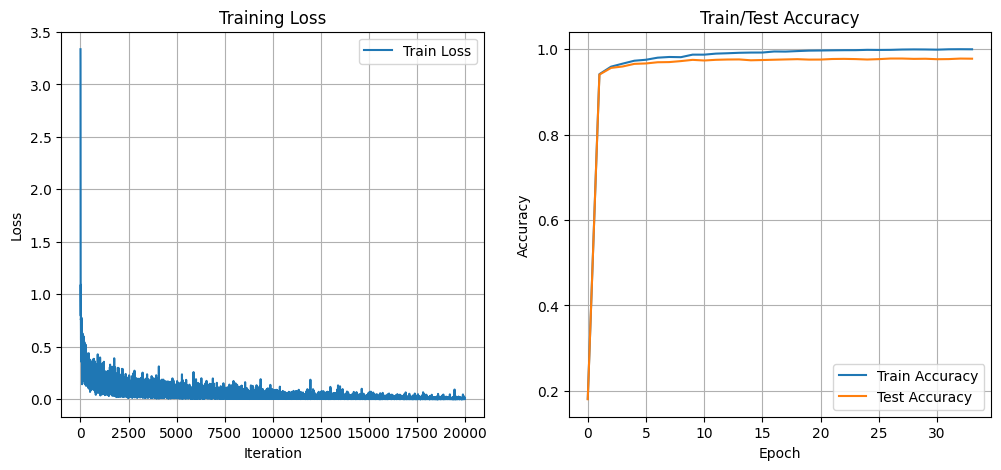

In [4]:

# 손실 그래프
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train Loss')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.legend()

# 정확도 그래프 (Train vs Test)
plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(test_acc_list, label='Test Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train/Test Accuracy")
plt.grid(True)
plt.legend()
plt.show()
plt.close()

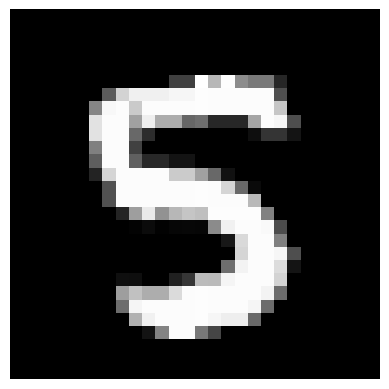

predicted value is:  5
true target is:  5


In [6]:
# test a sample
sample_id = 120 #pick a number
network.predict(sample_id)